# Neural Network Classifier & Regressor

In this tutorial we show how the `NeuralNetworkRegressor` is used.
It takes as an input a (Quantum) `NeuralNetwork` and leverage it in a specific context.
We also provide a pre-configured variant for convenience, the Variational Quantum Regressor (`VQR`). The tutorial is structured as follows:
 
    
[Regression](#Regression)
    * Regression with an `EstimatorQNN`
    * Variational Quantum Regressor (`VQR`)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, GradientDescent, SPSA, SLSQP
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

We will add a callback function called `callback_graph`. This will be called for each iteration of the optimizer and will be passed two parameters: the current weights and the value of the objective function at those weights. For our function, we append the value of the objective function to an array so we can plot iteration versus objective function value and update the graph with each iteration. However, you can do whatever you want with a callback function as long as it gets the two parameters mentioned passed. 

In [2]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

## Regression

We prepare a simple regression dataset to illustrate the following algorithms.

In [3]:
num_samples = 30
eps = 0.2 # Epsiion de diferencia entre el valor real, y el valor del dataset para ajustar por regresión.
# https://www.researchgate.net/post/What_is_the_problem_with_epsilon0_in_regression_problems_with_Support_Vector_Regression2

lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)


In [4]:
f = lambda x: np.sin(x)

In [5]:
X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb

In [6]:
y = f(X[:, 0])  + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

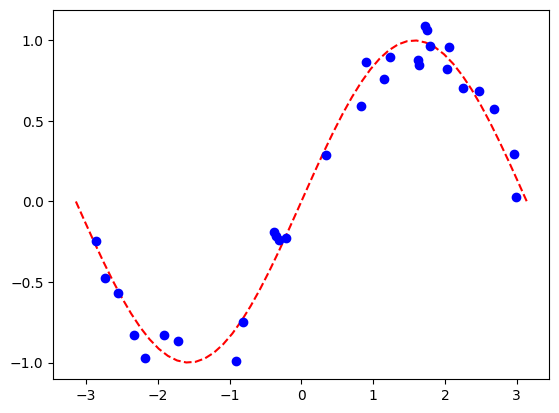

In [7]:
plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

### Regression with an `EstimatorQNN`

Here we restrict to regression with an `EstimatorQNN` that returns values in $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `SamplerQNN` but that exceeds the scope of this tutorial.

In [8]:
#feature_map = ZFeatureMap(1, reps=1)
#ansatz = RealAmplitudes(1, reps=1)

In [9]:
#feature_map = ZFeatureMap(1)
#ansatz = RealAmplitudes(1, reps=3)

In [10]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

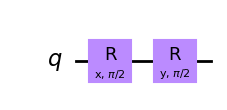

In [11]:
qc.decompose().draw(output="mpl")

In [12]:
# construct QNN
regression_estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [13]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=SLSQP(maxiter=10),
    callback=callback_graph,
)

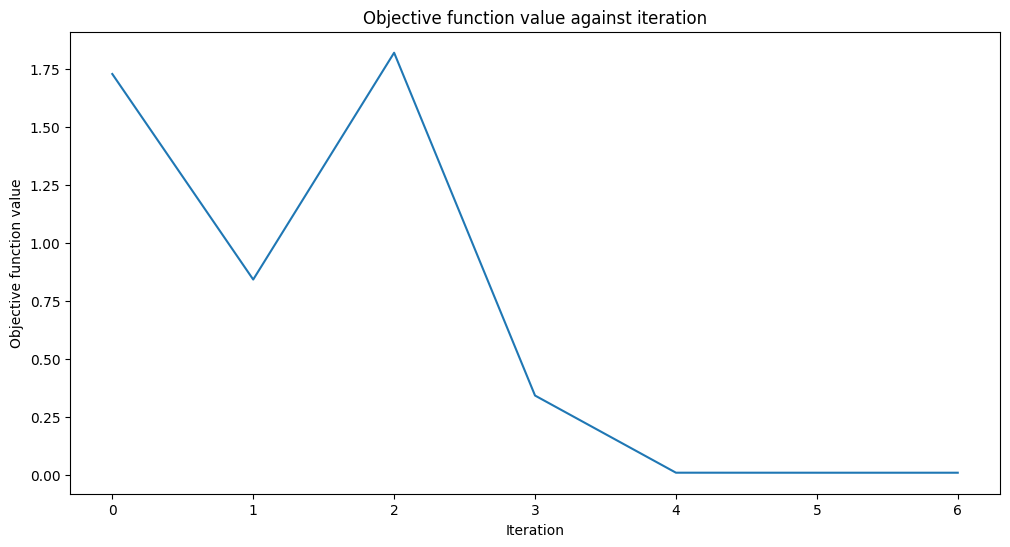

0.9771736619127632

In [14]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

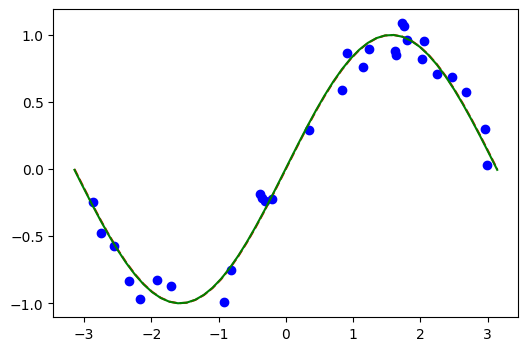

In [15]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

Similarly to the classification models, we can obtain an array of trained weights by querying a corresponding property of the model. In this model we have only one parameter defined as `param_y` above.

In [16]:
regressor.weights

array([-1.56552066])

### Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with a `EstimatorQNN`. By default it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [17]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=SLSQP(maxiter=5),
    callback=callback_graph,
)

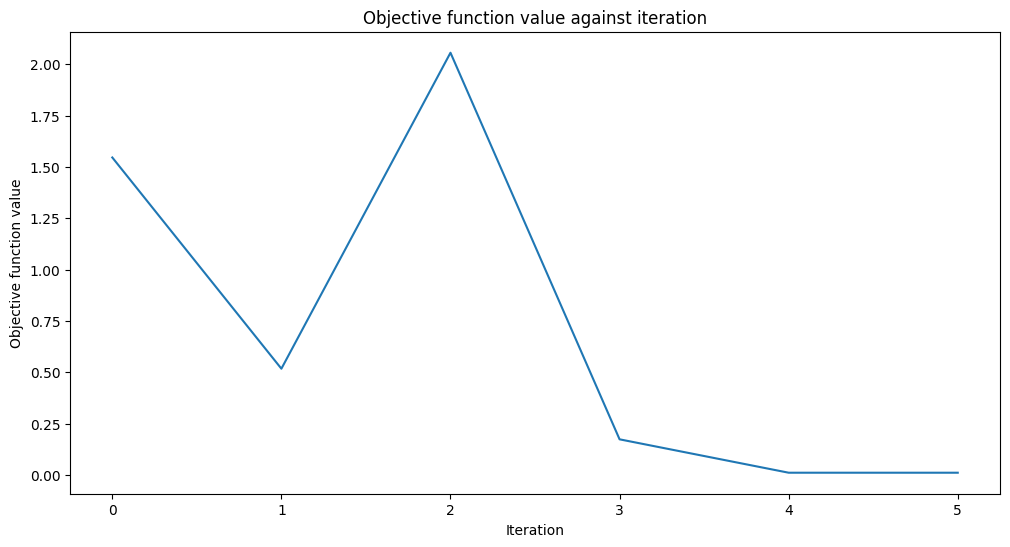

0.977172911976369

In [18]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

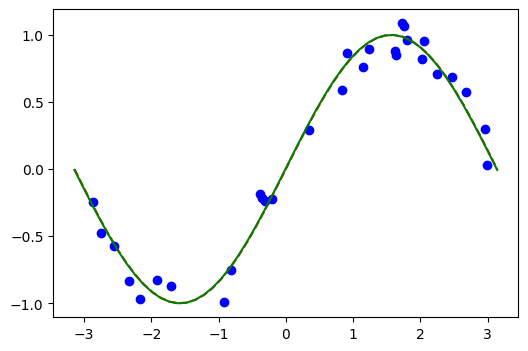

In [19]:
# plot target function
plt.plot(X_, f(X_), "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-")
plt.show()

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright